# Setting

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import warnings
import datetime
import pickle
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# 1. 데이터 불러오기 및 확인

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Dropoff는 현재값이니까 삭제한다.
train = train.drop('Dropoff', axis=1)
test = test.drop('Dropoff', axis=1)

In [5]:
print("train shape =", train.shape)
print("test shape =", test.shape)

train shape = (380800, 83)
test shape = (188800, 83)


In [7]:
train[['Pickup']].describe(percentiles = [0.25,0.5,0.75,0.9,0.99, 0.999]).T

,count,mean,std,min,25%,50%,75%,90%,99%,99.9%,max
Pickup,380800.0,37.770919,106.091875,0.0,0.0,0.0,9.0,118.0,547.0,825.201,1149.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380800 entries, 0 to 380799
Data columns (total 83 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pickup    380800 non-null  float64
 1   Clust     380800 non-null  int64  
 2   Thur      380800 non-null  float64
 3   Fri       380800 non-null  float64
 4   Sat       380800 non-null  float64
 5   Sun       380800 non-null  float64
 6   Mon       380800 non-null  float64
 7   Tue       380800 non-null  float64
 8   Weds      380800 non-null  float64
 9   Holi      380800 non-null  float64
 10  PrevHoli  380800 non-null  float64
 11  T0        380800 non-null  float64
 12  T1        380800 non-null  float64
 13  T2        380800 non-null  float64
 14  T3        380800 non-null  float64
 15  T4        380800 non-null  float64
 16  T5        380800 non-null  float64
 17  T6        380800 non-null  float64
 18  T7        380800 non-null  float64
 19  T8        380800 non-null  float64
 20  T9  

In [9]:
print(train.shape,test.shape)

(380800, 83) (188800, 83)


In [10]:
train_y = train['Pickup']
train_x = train.drop('Pickup', axis = 1)
test_y = test['Pickup']
test_x = test.drop('Pickup', axis = 1)

In [11]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(380800, 82) (380800,) (188800, 82) (188800,)


# 2. 모델링

In [128]:
def mape_trs(y_true, y_pred, trs=11):
    true_mask = y_true>=trs
    tmp_abs = np.divide(np.abs(y_true-y_pred)[true_mask] , y_true[true_mask])
    rtn = (np.average(tmp_abs))
    return rtn

def rmse_trs(y_true,y_pred, trs=11):
    true_mask = y_true>=trs
    tmp_abs = np.sqrt(np.average(np.square(y_pred-y_true)[true_mask]))
    return tmp_abs

## (1) Random Forest

### Case1

In [12]:
start = time.time()
rf1 = RandomForestRegressor(random_state=777)
rf1.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

실행시간:501.5794234275818


In [146]:
pred_y11 = rf1.predict(test_x)

In [136]:
print(rmse_trs(test_y, pred_y11, trs=11))
print(mape_trs(test_y, pred_y11, trs=11))

26.478784403015826
0.16852618604875708


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


Text(0.5, 1.0, 'Obs vs Fitted for Random Forest Case 1')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


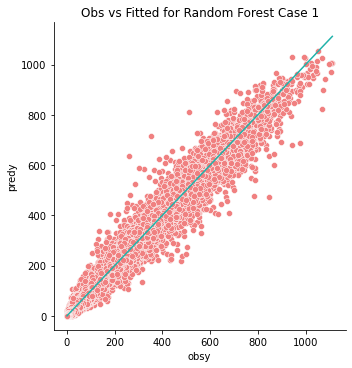

In [29]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_y11})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_y) , np.max(test_y)], [np.min(test_y) , np.max(test_y)], color="lightseagreen")
plt.title("Obs vs Fitted for Random Forest Case 1")

In [30]:
# pseudo R^2
1 - sum((test_y - pred_y11)**2) / sum((test_y - np.mean(test_y))**2)

0.9855947028515714

Text(0.5, 1.0, 'Feature importance for Random Forest Case 1')

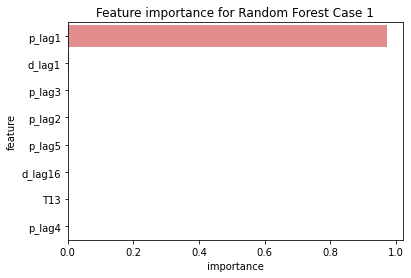

In [32]:
feature_importance_loc=rf1.feature_importances_
df_loc=pd.DataFrame({'feature':train_x.columns,'importance':feature_importance_loc}).sort_values('importance',ascending=False).iloc[:8]
sns.barplot(x='importance',y='feature',data=df_loc,color='lightcoral')
plt.title("Feature importance for Random Forest Case 1")

In [34]:
df_loc

,feature,importance
58,p_lag1,0.971095
66,d_lag1,0.002459
60,p_lag3,0.002069
59,p_lag2,0.001601
62,p_lag5,0.001478
81,d_lag16,0.001233
23,T13,0.001162
61,p_lag4,0.001020


### Case 2 : Random Search

In [35]:
start = time.time()
rf2 = RandomForestRegressor()
rf_grid = {
    'max_depth':[2, 8],
    'n_estimators':[500, 1000],
    'random_state':[777]
}
rfCV = RandomizedSearchCV(rf2, rf_grid, verbose=2)
rfCV.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
print(rfCV.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....max_depth=2, n_estimators=500, random_state=777; total time= 2.8min
[CV] END ....max_depth=2, n_estimators=500, random_state=777; total time= 2.5min
[CV] END ....max_depth=2, n_estimators=500, random_state=777; total time= 2.5min
[CV] END ....max_depth=2, n_estimators=500, random_state=777; total time= 2.5min
[CV] END ....max_depth=2, n_estimators=500, random_state=777; total time= 2.6min
[CV] END ...max_depth=2, n_estimators=1000, random_state=777; total time= 5.3min
[CV] END ...max_depth=2, n_estimators=1000, random_state=777; total time= 5.0min
[CV] END ...max_depth=2, n_estimators=1000, random_state=777; total time= 5.0min
[CV] END ...max_depth=2, n_estimators=1000, random_state=777; total time= 5.0min
[CV] END ...max_depth=2, n_estimators=1000, random_state=777; total time= 5.3min
[CV] END ....max_depth=8, n_estimators=500, random_state=777; total time=10.5min
[CV] END ....max_depth=8, n_estimators=500, rando

In [43]:
# best parameter 사용
start = time.time()
rf2 = RandomForestRegressor(max_depth=8, 
                            n_estimators=1000, 
                            random_state=777)
rf2.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

실행시간:1535.0397748947144


In [127]:
# model save
rf_filename = 'rf.sav'
pickle.dump(rf1, open(rf_filename, 'wb'))

In [147]:
pred_y12 = rf2.predict(test_x)

In [137]:
print(rmse_trs(test_y, pred_y12, trs=11))
print(mape_trs(test_y, pred_y12, trs=11))

31.28901519709064
0.20273550213778824


Text(0.5, 1.0, 'Obs vs Fitted for Random Forest Case 2')

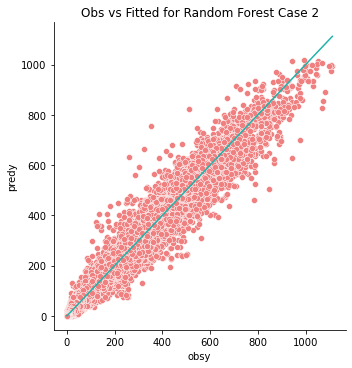

In [46]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_y12})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_y) , np.max(test_y)], [np.min(test_y) , np.max(test_y)], color="lightseagreen")
plt.title("Obs vs Fitted for Random Forest Case 2")

In [47]:
# pseudo R^2
1 - sum((test_y - pred_y12)**2) / sum((test_y - np.mean(test_y))**2)

0.9799009642148688

Text(0.5, 1.0, 'Feature importance for Random Forest Case 2')

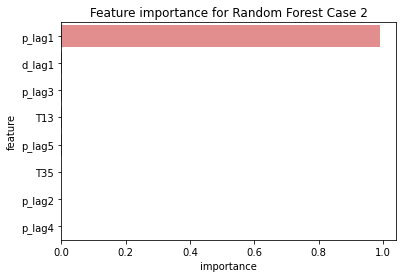

In [50]:
feature_importance_loc=rf2.feature_importances_
df_loc=pd.DataFrame({'feature':train_x.columns,'importance':feature_importance_loc}).sort_values('importance',ascending=False).iloc[:8]
sns.barplot(x='importance',y='feature',data=df_loc,color='lightcoral')
plt.title("Feature importance for Random Forest Case 2")

In [49]:
df_loc

,feature,importance
58,p_lag1,0.990812
66,d_lag1,0.001265
60,p_lag3,0.001204
23,T13,0.001184
62,p_lag5,0.000754
45,T35,0.000401
59,p_lag2,0.000327
61,p_lag4,0.000313


## (2) XGBoost

### Case1 : Parameters in the Paper

In [51]:
start = time.time()
xgb1 = xgboost.XGBRegressor(max_depth=4, n_estimators=500, subsample=0.6, learning_rate=0.05, random_state=777)
xgb1.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

실행시간:49.524967193603516


In [148]:
pred_y21 = xgb1.predict(test_x)

In [138]:
print(rmse_trs(test_y, pred_y21, trs=11))
print(mape_trs(test_y, pred_y21, trs=11))

27.08377574468122
0.18872602254695237


Text(0.5, 1.0, 'Obs vs Fitted for XGboost Case 1')

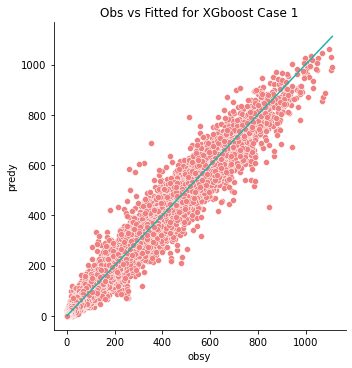

In [53]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_y21})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_y) , np.max(test_y)], [np.min(test_y) , np.max(test_y)], color="lightseagreen")
plt.title("Obs vs Fitted for XGboost Case 1")

In [54]:
# pseudo R^2
1 - sum((test_y - pred_y21)**2) / sum((test_y - np.mean(test_y))**2)

0.9849117415800156

Text(0.5, 1.0, 'Feature importance for XGboost Case 1')

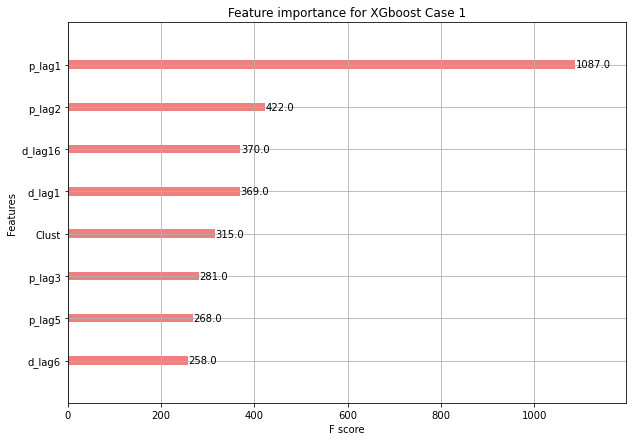

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_importance(xgb1, ax=ax, color="lightcoral", max_num_features=8)
plt.title("Feature importance for XGboost Case 1")

### Case2 : Random Search

In [56]:
start = time.time()
xgb2 = xgboost.XGBRegressor()
xgb_grid = {
    'max_depth':[2,8],
    'subsample' : [0.4,1],
    'gamma': [0, 0.2],
    'n_estimators':[500, 1000],
    'learning_rate':[0.05, 0.1],
    'random_state':[777]
}
xgbCV = RandomizedSearchCV(xgb2, xgb_grid, verbose=2)
xgbCV.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
print(xgbCV.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END gamma=0, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=777, subsample=0.4; total time= 1.2min
[CV] END gamma=0, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=777, subsample=0.4; total time= 1.2min
[CV] END gamma=0, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=777, subsample=0.4; total time= 1.2min
[CV] END gamma=0, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=777, subsample=0.4; total time= 1.2min
[CV] END gamma=0, learning_rate=0.05, max_depth=8, n_estimators=500, random_state=777, subsample=0.4; total time= 1.2min
[CV] END gamma=0.2, learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=777, subsample=0.4; total time= 2.4min
[CV] END gamma=0.2, learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=777, subsample=0.4; total time= 2.4min
[CV] END gamma=0.2, learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=7

In [58]:
# best parameter 사용
start = time.time()
xgb2 = xgboost.XGBRegressor(subsample=1, 
                            n_estimators=500,
                            max_depth=8,
                            learning_rate=0.05,
                            gamma=0,
                            random_state=777)
xgb2.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

실행시간:73.18326044082642


In [59]:
# model save
xgb_filename = 'xgb.sav'
pickle.dump(xgb2, open(xgb_filename, 'wb'))

In [149]:
pred_y22 = xgb2.predict(test_x)

In [139]:
print(rmse_trs(test_y, pred_y22, trs=11))
print(mape_trs(test_y, pred_y22, trs=11))

24.79609928667544
0.1660845533432754


Text(0.5, 1.0, 'Obs vs Fitted for XGboost Case 2')

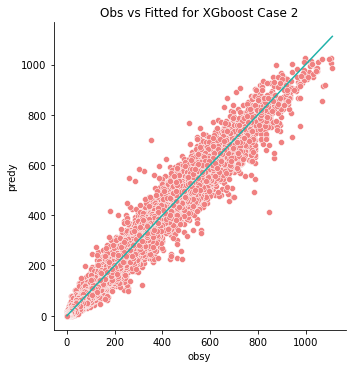

In [61]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_y22})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_y) , np.max(test_y)], [np.min(test_y) , np.max(test_y)], color="lightseagreen")
plt.title("Obs vs Fitted for XGboost Case 2")

In [62]:
# pseudo R^2
1 - sum((test_y - pred_y22)**2) / sum((test_y - np.mean(test_y))**2)

0.9873524569148265

Text(0.5, 1.0, 'Feature importance for XGboost Case 2')

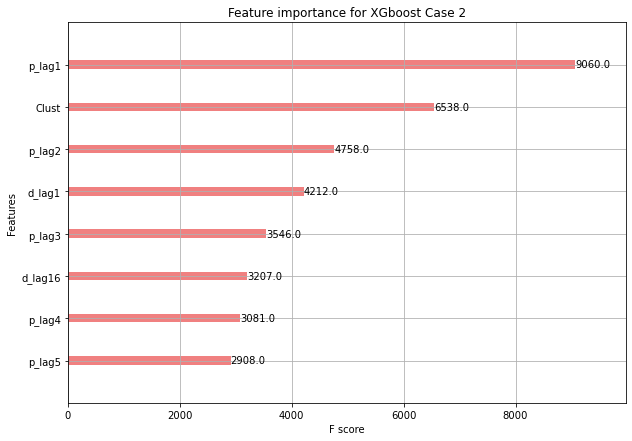

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_importance(xgb2, ax=ax, color="lightcoral", max_num_features=8)
plt.title("Feature importance for XGboost Case 2")

## (3) CATboost

In [66]:
from catboost import CatBoostRegressor, Pool, metrics, cv

- CATboost를 위한 데이터 만들기

In [71]:
# train
# 요일
DayofWeek = train.iloc[:,2:8]
DayofWeek = pd.get_dummies(DayofWeek).idxmax(1)
DayofWeek = DayofWeek.to_frame(name = 'Week')

# 시간
TimeBin = train.iloc[:,11:59]
TimeBin = pd.get_dummies(TimeBin).idxmax(1)
TimeBin = TimeBin.to_frame(name = '30min')

# Train for CATBoost
Head = train.iloc[:,0:2]
Hoil = train.iloc[:,9:11]
Last = train.iloc[:,59:]
train_cat = pd.concat([Head,DayofWeek,Hoil,TimeBin,Last], axis = 1)

In [72]:
# test
# 요일
DayofWeek = test.iloc[:,2:8]
DayofWeek = pd.get_dummies(DayofWeek).idxmax(1)
DayofWeek = DayofWeek.to_frame(name = 'Week')

# 시간
TimeBin = test.iloc[:,11:59]
TimeBin = pd.get_dummies(TimeBin).idxmax(1)
TimeBin = TimeBin.to_frame(name = '30min')

# Train for CATBoost
Head = test.iloc[:,0:2]
Hoil = test.iloc[:,9:11]
Last = test.iloc[:,59:]
test_cat = pd.concat([Head,DayofWeek,Hoil,TimeBin,Last], axis = 1)

In [109]:
train_yy = train_cat['Pickup']
train_xx = train_cat.drop(['Pickup'], axis = 1)
test_yy = test_cat['Pickup']
test_xx = test_cat.drop(['Pickup'], axis = 1)

In [110]:
cat_features = ['Week', '30min','Holi','PrevHoli']

train_xx[cat_features] = train_xx[cat_features].astype(str)
test_xx[cat_features] = test_xx[cat_features].astype(str)

### Case 1 : Plain

In [114]:
start = time.time()
cat1 = CatBoostRegressor(random_seed=777,
                          iterations=1000,
                          loss_function="RMSE")
cat1.fit(train_xx, train_yy, cat_features = ['Week', '30min','Holi','PrevHoli'])
print("실행시간:{}".format(time.time()-start))

Learning rate set to 0.104696
0:	learn: 95.7605043	total: 96.1ms	remaining: 1m 36s
1:	learn: 86.3693785	total: 168ms	remaining: 1m 23s
2:	learn: 78.0170587	total: 238ms	remaining: 1m 19s
3:	learn: 70.6862055	total: 306ms	remaining: 1m 16s
4:	learn: 64.0326335	total: 381ms	remaining: 1m 15s
5:	learn: 58.0816503	total: 448ms	remaining: 1m 14s
6:	learn: 52.7882894	total: 514ms	remaining: 1m 12s
7:	learn: 48.1206691	total: 582ms	remaining: 1m 12s
8:	learn: 43.9874760	total: 654ms	remaining: 1m 12s
9:	learn: 40.3678518	total: 729ms	remaining: 1m 12s
10:	learn: 37.1581956	total: 798ms	remaining: 1m 11s
11:	learn: 34.3619847	total: 867ms	remaining: 1m 11s
12:	learn: 31.8680794	total: 930ms	remaining: 1m 10s
13:	learn: 29.7378580	total: 1.01s	remaining: 1m 11s
14:	learn: 27.8760437	total: 1.09s	remaining: 1m 11s
15:	learn: 26.2473620	total: 1.16s	remaining: 1m 11s
16:	learn: 24.8612824	total: 1.22s	remaining: 1m 10s
17:	learn: 23.6449130	total: 1.3s	remaining: 1m 10s
18:	learn: 22.6116678	tota

In [150]:
pred_y31 = cat1.predict(test_xx)

In [140]:
print(rmse_trs(test_y, pred_y31, trs=11))
print(mape_trs(test_y, pred_y31, trs=11))

25.366360297430283
0.17398081704841095


Text(0.5, 1.0, 'Obs vs Fitted for CATboost Case 1')

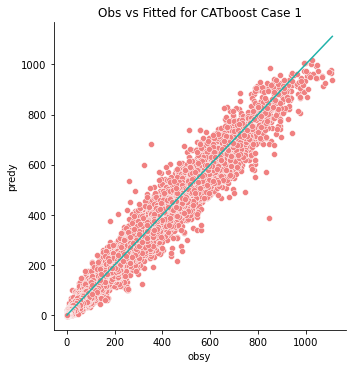

In [116]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_yy, 'predy':pred_y31})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_yy) , np.max(test_yy)], [np.min(test_yy) , np.max(test_yy)], color="lightseagreen")
plt.title("Obs vs Fitted for CATboost Case 1")

In [117]:
# pseudo R^2
1 - sum((test_yy - pred_y31)**2) / sum((test_yy - np.mean(test_yy))**2)

0.9867585183991111

Text(0.5, 1.0, 'Feature importance for CATboost Case 1')

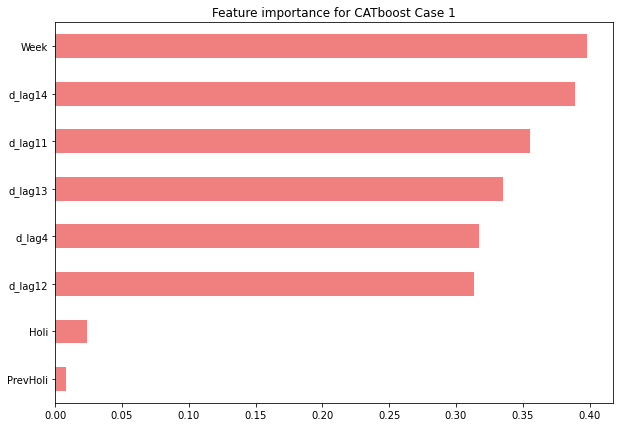

In [119]:
imp1 = cat1.get_feature_importance(type = 'FeatureImportance', thread_count = -1)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
pd.Series(imp1, index=train_xx.columns).nsmallest(8).plot(kind='barh',color="lightcoral")
plt.title("Feature importance for CATboost Case 1")

### Case 2 : Ordered

In [120]:
start = time.time()
cat2 = CatBoostRegressor(boosting_type = 'Ordered',
                         random_seed=777,
                         iterations=1000,
                         loss_function="RMSE")
cat2.fit(train_xx, train_yy,cat_features = ['Week', '30min','Holi','PrevHoli'])
print("실행시간:{}".format(time.time()-start))

Learning rate set to 0.104696
0:	learn: 95.7605043	total: 110ms	remaining: 1m 50s
1:	learn: 86.3717476	total: 229ms	remaining: 1m 54s
2:	learn: 78.0597961	total: 344ms	remaining: 1m 54s
3:	learn: 70.7426351	total: 456ms	remaining: 1m 53s
4:	learn: 64.1020003	total: 577ms	remaining: 1m 54s
5:	learn: 58.1501679	total: 697ms	remaining: 1m 55s
6:	learn: 52.9054907	total: 816ms	remaining: 1m 55s
7:	learn: 48.2436595	total: 934ms	remaining: 1m 55s
8:	learn: 44.1394975	total: 1.04s	remaining: 1m 54s
9:	learn: 40.4681282	total: 1.16s	remaining: 1m 54s
10:	learn: 37.2667937	total: 1.28s	remaining: 1m 54s
11:	learn: 34.4197275	total: 1.39s	remaining: 1m 54s
12:	learn: 31.9460375	total: 1.5s	remaining: 1m 53s
13:	learn: 29.7932679	total: 1.61s	remaining: 1m 53s
14:	learn: 27.9139595	total: 1.73s	remaining: 1m 53s
15:	learn: 26.2788227	total: 1.84s	remaining: 1m 53s
16:	learn: 24.8799219	total: 1.95s	remaining: 1m 53s
17:	learn: 23.6845488	total: 2.07s	remaining: 1m 52s
18:	learn: 22.6591623	total

In [151]:
pred_y32 = cat2.predict(test_xx)

In [141]:
print(rmse_trs(test_y, pred_y32, trs=11))
print(mape_trs(test_y, pred_y32, trs=11))

26.919939385736647
0.1856684025582711


Text(0.5, 1.0, 'Obs vs Fitted for CATboost Case 2')

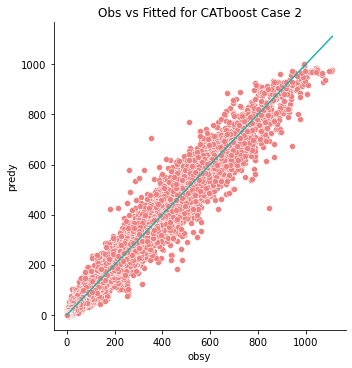

In [122]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_yy, 'predy':pred_y32})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_yy) , np.max(test_yy)], [np.min(test_yy) , np.max(test_yy)], color="lightseagreen")
plt.title("Obs vs Fitted for CATboost Case 2")

In [123]:
# pseudo R^2
1 - sum((test_yy - pred_y32)**2) / sum((test_yy - np.mean(test_yy))**2)

0.9850907058718787

Text(0.5, 1.0, 'Feature importance for CATboost Case 2')

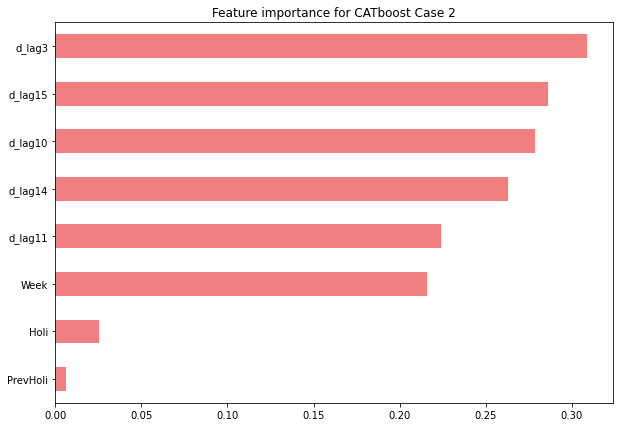

In [124]:
imp2 = cat2.get_feature_importance(type = 'FeatureImportance', thread_count = -1)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
pd.Series(imp2, index=train_xx.columns).nsmallest(8).plot(kind='barh',color="lightcoral")
plt.title("Feature importance for CATboost Case 2")

### Case 3 : Random Search

In [126]:
start = time.time()
cat3 = CatBoostRegressor()
cat_grid = {
    'depth':[2,8],
    'learning_rate':[0.05, 0.1],
    'iterations':[500,1000],
    'random_state':[777]
}
catCV = RandomizedSearchCV(cat3, cat_grid, verbose=2)
catCV.fit(train_xx, train_yy,cat_features = ['Week', '30min','Holi','PrevHoli'])
print("실행시간:{}".format(time.time()-start))
print(catCV.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 107.9846052	total: 34ms	remaining: 17s
1:	learn: 103.4807763	total: 58ms	remaining: 14.5s
2:	learn: 99.0861987	total: 79.6ms	remaining: 13.2s
3:	learn: 94.9032851	total: 101ms	remaining: 12.5s
4:	learn: 91.0098371	total: 124ms	remaining: 12.3s
5:	learn: 87.1511013	total: 146ms	remaining: 12s
6:	learn: 83.5934179	total: 166ms	remaining: 11.7s
7:	learn: 80.2709674	total: 187ms	remaining: 11.5s
8:	learn: 77.0746148	total: 208ms	remaining: 11.3s
9:	learn: 73.9467333	total: 229ms	remaining: 11.2s
10:	learn: 71.0290578	total: 251ms	remaining: 11.1s
11:	learn: 68.3182058	total: 272ms	remaining: 11s
12:	learn: 65.6709207	total: 292ms	remaining: 11s
13:	learn: 63.1333958	total: 308ms	remaining: 10.7s
14:	learn: 60.8525441	total: 329ms	remaining: 10.6s
15:	learn: 58.6645409	total: 357ms	remaining: 10.8s
16:	learn: 56.5537862	total: 378ms	remaining: 10.7s
17:	learn: 54.5596593	total: 399ms	remaining: 10.7s
18:	learn: 52.5678599

In [129]:
# best parameter 사용
start = time.time()
cat3 = CatBoostRegressor(depth=8,
                        learning_rate=0.1,
                        iterations=1000,
                        random_state=777)
cat3.fit(train_xx, train_yy,cat_features = ['Week', '30min','Holi','PrevHoli'])
print("실행시간:{}".format(time.time()-start))

0:	learn: 96.0914544	total: 124ms	remaining: 2m 3s
1:	learn: 87.1899079	total: 264ms	remaining: 2m 11s
2:	learn: 79.0454976	total: 377ms	remaining: 2m 5s
3:	learn: 71.7402247	total: 479ms	remaining: 1m 59s
4:	learn: 65.2287256	total: 583ms	remaining: 1m 55s
5:	learn: 59.3966804	total: 684ms	remaining: 1m 53s
6:	learn: 54.1867082	total: 787ms	remaining: 1m 51s
7:	learn: 49.5090718	total: 904ms	remaining: 1m 52s
8:	learn: 45.3277187	total: 1.02s	remaining: 1m 52s
9:	learn: 41.6231045	total: 1.13s	remaining: 1m 51s
10:	learn: 38.3269655	total: 1.23s	remaining: 1m 50s
11:	learn: 35.4162195	total: 1.33s	remaining: 1m 49s
12:	learn: 32.8638816	total: 1.44s	remaining: 1m 49s
13:	learn: 30.6173071	total: 1.56s	remaining: 1m 50s
14:	learn: 28.6381047	total: 1.66s	remaining: 1m 49s
15:	learn: 26.9165259	total: 1.76s	remaining: 1m 48s
16:	learn: 25.4079289	total: 1.86s	remaining: 1m 47s
17:	learn: 24.0807199	total: 1.96s	remaining: 1m 46s
18:	learn: 22.9371310	total: 2.08s	remaining: 1m 47s
19:	l

In [152]:
pred_y33 = cat3.predict(test_xx)

In [142]:
print(rmse_trs(test_y, pred_y33, trs=11))
print(mape_trs(test_y, pred_y33, trs=11))

24.835497404724077
0.16836957776814213


In [131]:
# model save
cat_filename = 'cat.sav'
pickle.dump(cat3, open(cat_filename, 'wb'))

Text(0.5, 1.0, 'Obs vs Fitted for CATboost Case 3')

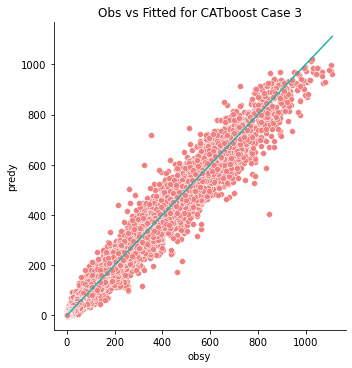

In [132]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_yy, 'predy':pred_y33})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_yy) , np.max(test_yy)], [np.min(test_yy) , np.max(test_yy)], color="lightseagreen")
plt.title("Obs vs Fitted for CATboost Case 3")

In [133]:
# pseudo R^2
1 - sum((test_yy - pred_y33)**2) / sum((test_yy - np.mean(test_yy))**2)

0.9873057574536939

Text(0.5, 1.0, 'Feature importance for CATboost Case 3')

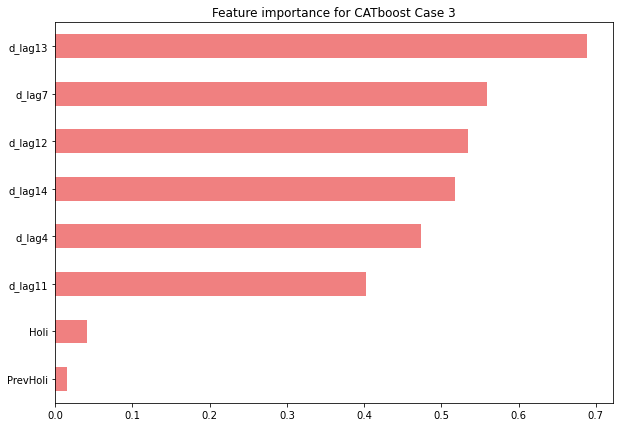

In [134]:
imp3 = cat3.get_feature_importance(type = 'FeatureImportance', thread_count = -1)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
pd.Series(imp3, index=train_xx.columns).nsmallest(8).plot(kind='barh',color="lightcoral")
plt.title("Feature importance for CATboost Case 3")

## (4) LGBM

In [76]:
from lightgbm import plot_importance
from lightgbm import LGBMRegressor
import lightgbm as lgb

### Case1

In [77]:
start = time.time()
lgbm1 = LGBMRegressor(random_state=777)
lgbm1.fit(train_x, train_y, eval_metric="rmse", verbose=True)
print("실행시간:{}".format(time.time()-start))

실행시간:0.7879745960235596


In [153]:
pred_y41 = lgbm1.predict(test_x)

In [143]:
print(rmse_trs(test_y, pred_y41, trs=11))
print(mape_trs(test_y, pred_y41, trs=11))

26.485084947195457
0.18442847826090636


Text(0.5, 1.0, 'Obs vs Fitted for LGBM Case 1')

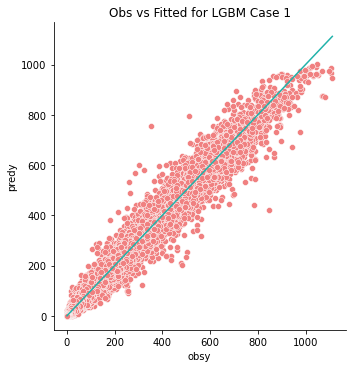

In [79]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_y41})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_y) , np.max(test_y)], [np.min(test_y) , np.max(test_y)], color="lightseagreen")
plt.title("Obs vs Fitted for LGBM Case 1")

In [80]:
# pseudo R^2
1 - sum((test_y - pred_y41)**2) / sum((test_y - np.mean(test_y))**2)

0.985563370692696

Text(0.5, 1.0, 'Feature importance for LGBM Case 1')

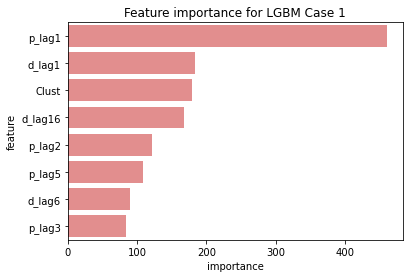

In [81]:
# feature importance plot
feature_importance_loc = lgbm1.feature_importances_
df_loc = pd.DataFrame({'feature':train_x.columns, 'importance':feature_importance_loc}).sort_values('importance',ascending=False).iloc[:8]
sns.barplot(x='importance', y='feature', data=df_loc, color="lightcoral")
plt.title("Feature importance for LGBM Case 1")

### Case2 : Random Search

In [85]:
import lightgbm as lgb 
start = time.time()
lgbm2 = lgb.LGBMRegressor(boosting_type ="gbdt", metric="rmse")
lgbm_grid  = {'num_leaves':[20,31],
              'max_depth':[-1,8],
              "feature_fraction":[0.2,1],
              'learning_rate':[0.05,0.1],
             } 
lgbmCV  = RandomizedSearchCV(lgbm2, lgbm_grid, cv=3) 
lgbmCV.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
print(lgbmCV.best_params_) 

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning]

In [86]:
# best parameter 사용
start = time.time()
lgbm2 = LGBMRegressor(boosting_type ="gbdt",
                      metric="rmse",
                      num_leaves=20,
                      max_depth =8,
                      learning_rate=0.1,
                      feature_fraction=1,
                      random_state=777)
lgbm2.fit(train_x, train_y, eval_metric="rmse", verbose=True)
print("실행시간:{}".format(time.time()-start))

실행시간:0.7015604972839355


In [154]:
pred_y42 = lgbm2.predict(test_x)

In [144]:
print(rmse_trs(test_y, pred_y42, trs=11))
print(mape_trs(test_y, pred_y42, trs=11))

27.259187176938994
0.18916732654917875


In [145]:
# model save
lgbm_filename = 'lgbm.sav'
pickle.dump(lgbm1, open(lgbm_filename, 'wb'))

Text(0.5, 1.0, 'Obs vs Fitted for LGBM Case 2')

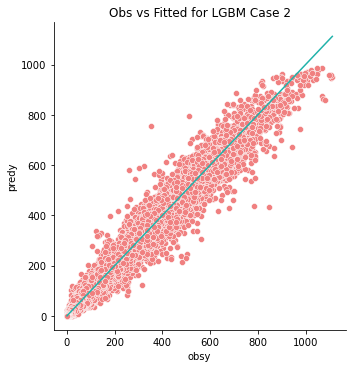

In [89]:
# observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':pred_y42})
sns.relplot(x='obsy', y='predy', data=y_df, color="lightcoral")
plt.plot([np.min(test_y) , np.max(test_y)], [np.min(test_y) , np.max(test_y)], color="lightseagreen")
plt.title("Obs vs Fitted for LGBM Case 2")

In [90]:
# pseudo R^2
1 - sum((test_y - pred_y42)**2) / sum((test_y - np.mean(test_y))**2)

0.9847114619840491

Text(0.5, 1.0, 'Feature importance for LGBM Case 2')

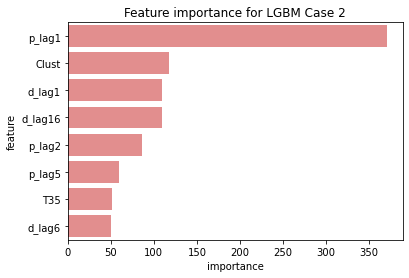

In [91]:
# feature importance plot
feature_importance_loc = lgbm2.feature_importances_
df_loc = pd.DataFrame({'feature':train_x.columns, 'importance':feature_importance_loc}).sort_values('importance',ascending=False).iloc[:8]
sns.barplot(x='importance', y='feature', data=df_loc, color="lightcoral")
plt.title("Feature importance for LGBM Case 2")

## (5) Baseline model

- y_pred 대신 p_lag1

In [155]:
pred_y51 = test_x['p_lag1']

In [156]:
print(rmse_trs(test_y, pred_y51, trs=11))
print(mape_trs(test_y, pred_y51, trs=11))

37.09267721234587
0.2254179042699946


In [97]:
# pseudo R^2
1 - sum((test_y - pred_y51)**2) / sum((test_y - np.mean(test_y))**2)

0.9717990066749056

- RMSE, MAPE 기준으로 하였을 때 머신러닝 중 최적의 모델의 XGB이다.